In [ ]:
import os
from fastai.data.external import untar_data, URLs

import torch
import torchvision
import torch.nn as nn

import numpy as np

import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Downloading the dataset

In [ ]:
data_dir = untar_data(URLs.CIFAR)
data_dir = str(data_dir)

Checking all the directories in the data downloaded and checking the classes

In [ ]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['labels.txt', 'test', 'train']
['horse', 'ship', 'frog', 'automobile', 'dog', 'bird', 'deer', 'truck', 'airplane', 'cat']


In [ ]:
classes = os.listdir(data_dir + "/test")
print(classes)

['horse', 'ship', 'frog', 'automobile', 'dog', 'bird', 'deer', 'truck', 'airplane', 'cat']


Plots 10 different random images from the dataset every time it runs from each of the 10 classes

In [ ]:
def show_images(dataset='train'):
    next_pix= []
    # Parameters for our graph; we'll output images in a 5x2 configuration
    nrows = 5
    ncols = 2

    fig = plt.gcf()
    fig.set_size_inches(ncols * 5, nrows * 5)
    for i in range(len(classes)):
        next_pix.append(os.path.join(data_dir,dataset,classes[i]))
        img = mpimg.imread(os.path.join(next_pix[i],random.choice(os.listdir(next_pix[i]))))
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(img)
        plt.title(classes[i])

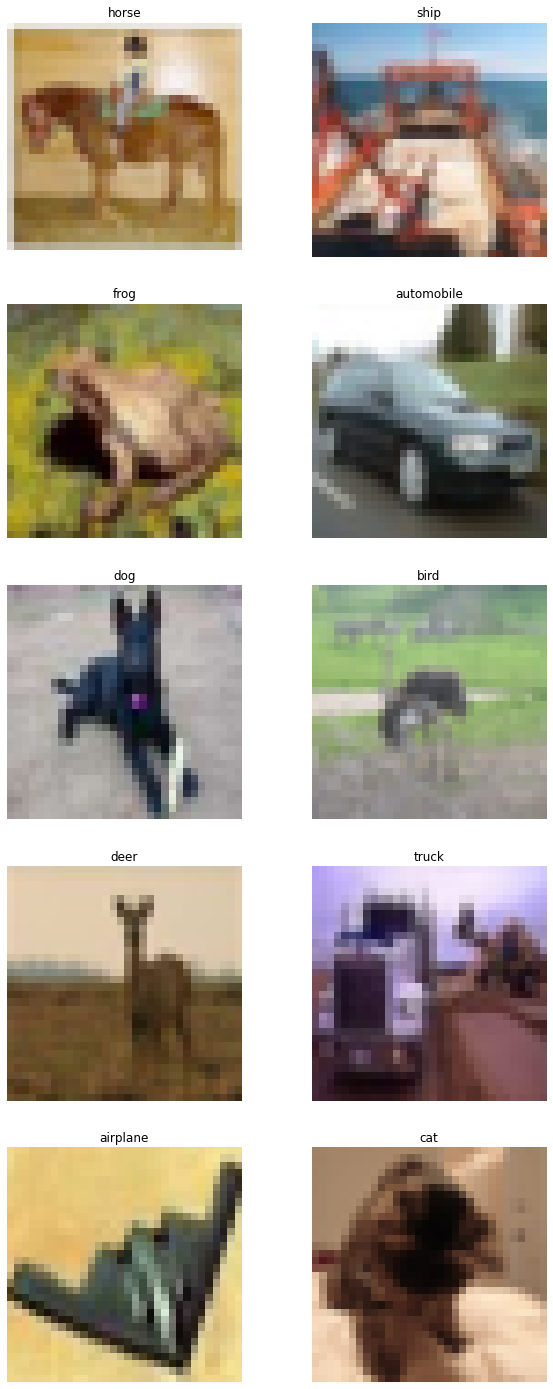

In [ ]:
show_images('test')

Creating dataloaders and converting to tensors for calculation of mean and std.

In [ ]:
dataset = ImageFolder(data_dir+'/', transform=tt.ToTensor())
dataloader = DataLoader(dataset, batch_size=512)

Calculating the mean and std of the images for normalization.

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    print(channels_sum,channels_squared_sum,num_batches)
    return mean, std

In [ ]:
print(get_mean_and_std(dataloader))

tensor([58.0551, 56.9718, 52.8075]) tensor([35.7692, 34.5064, 31.7155]) 118
(tensor([0.4920, 0.4828, 0.4475]), tensor([0.2471, 0.2436, 0.2617]))


Transforming images to tensor, Normalizing the images from the mean and std calculated, and performing different kinds of data augmentation for the training set.

For the validation set images are transformed to tensors and the images are normalized.

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4828, 0.4475), (0.2471, 0.2436, 0.2617))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.RandomRotation(degrees=(0, 10)),
                         #tt.RandomPerspective(distortion_scale=0.14),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         #tt.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

Performing all transformations on the dataset.

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
batch_size = 400

Creating data loaders.

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Plotting a batch of dataset to check the images after the transformations.

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images, nrow=16).permute(1, 2, 0).clamp(0,1))
        break

Making grid of a batch to check the dataset

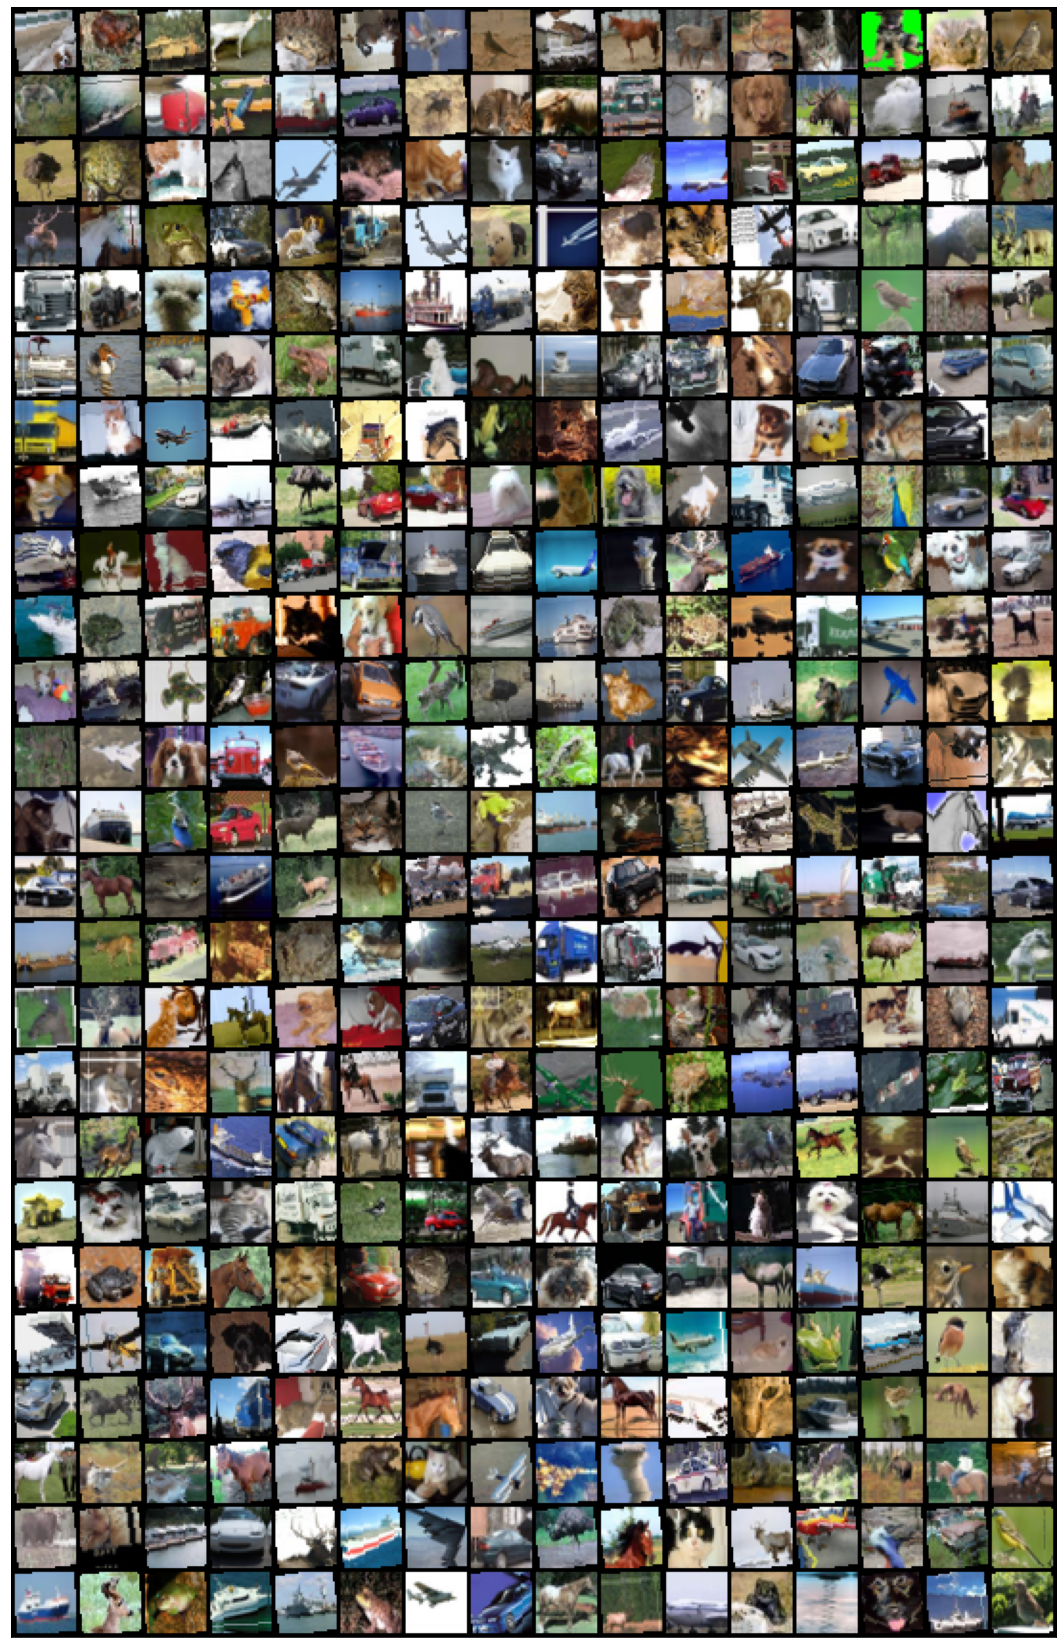

In [ ]:
show_batch(train_dl)

Checking the Device available and moving the model and dataset to that device using these functions

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Checking the Device available.

In [ ]:
device = get_default_device()
device

device(type='cuda')

Moving the dataset to the device available.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Defining functions for calculating accuracy and Loss

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, last_lr: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['lrs'][-1]))

Designing the residual model.

In [ ]:
def conv_block(in_channels, out_channels, activation=False, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels)]
    if activation: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet34(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=4),
            nn.BatchNorm2d(64),nn.ReLU(inplace=True))
           
        self.res1 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res2 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res3 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.downsample1=nn.Sequential(conv_block(64, 128,pool=True)) 
        self.res4 = nn.Sequential(conv_block(64, 128,activation=True, pool=True),
                                  conv_block(128,128))
        self.res5 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res6 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res7 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res8 = nn.Sequential(conv_block(128, 256,activation=True, pool=True),
                                  conv_block(256,256))
        self.downsample2 = nn.Sequential(conv_block(128, 256,pool=True))
        self.res9 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res10 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res11 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res12 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res13 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res14 = nn.Sequential(conv_block(256, 512,activation=True, pool=True),
                                   conv_block(512,512))
        
        self.downsample3 = nn.Sequential(conv_block(256, 512,pool=True))
        self.res15 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512))
        self.res16 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512,activation=True))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        self.apply(self.init_weights)

    def init_weights(self,m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.res2(out) + out
        out = self.res3(out) + out
        out = self.downsample1(out) +self.res4(out)
        out = self.res5(out) + out
        out = self.res6(out) + out
        out = self.res7(out) + out
        out = self.downsample2(out) +self.res8(out)
        out = self.res9(out) + out
        out = self.res10(out) + out
        out = self.res11(out) + out
        out = self.res12(out) + out
        out = self.res13(out) + out
        out = self.downsample3(out) + self.res14(out) 
        out = self.res15(out) + out
        out = self.res16(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = ResNet34(3, 10)

Installing torchinfo for summary of the model

In [ ]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchinfo import summary

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet34                                 [400, 10]                 --
├─Sequential: 1-1                        [400, 64, 34, 34]         --
│    └─Conv2d: 2-1                       [400, 64, 34, 34]         9,472
│    └─BatchNorm2d: 2-2                  [400, 64, 34, 34]         128
│    └─ReLU: 2-3                         [400, 64, 34, 34]         --
├─Sequential: 1-2                        [400, 64, 34, 34]         --
│    └─Sequential: 2-4                   [400, 64, 34, 34]         --
│    │    └─Conv2d: 3-1                  [400, 64, 34, 34]         36,928
│    │    └─BatchNorm2d: 3-2             [400, 64, 34, 34]         128
│    │    └─ReLU: 3-3                    [400, 64, 34, 34]         --
│    └─Sequential: 2-5                   [400, 64, 34, 34]         --
│    │    └─Conv2d: 3-4                  [400, 64, 34, 34]         36,928
│    │    └─BatchNorm2d: 3-5             [400, 64, 34, 34]         128
├

Checking the Device available and moving the model to that device

In [ ]:
model = to_device(ResNet34(3, 10), device)
model

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (res2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

Defining the evaluation function, updating the changed learning rate for the optimizer function and the fit function for backpropagation and model training.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,weight_decay=0, 
        bias_clip=False,grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    best_accuracy=0.00000
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,eta_min=0.000015,T_max=epochs*len(train_loader))
    for epoch in (range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        lrs=[]
        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            if bias_clip:
                params=model.state_dict()
                for name, param in model.named_parameters():
                    if 'bias' in name:
                        # Access the biases
                        params[name][:]=torch.clip(param, min=-0.055, max=0.045)
                model.load_state_dict(params)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            if batch_idx % 63 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.4f}'.
                format(epoch+1, batch_idx , len(train_loader),
                       100. * batch_idx / len(train_loader), loss,accuracy))
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if result['val_acc']>best_accuracy:
            torch.save(model.state_dict(), '/kaggle/working/cifar10-resnet34best.pth')
            best_accuracy=result['val_acc']
    return history

Checking the accuracy of model before training

In [ ]:
evaluate(model, valid_dl)

{'val_loss': 4243.63427734375, 'val_acc': 0.0954807698726654}

Stating the no. of epochs, learning rate, value for gradient clipping, value for weight decay, choosing if bias clip is going to be used or not and choosing the optimizer.

In [ ]:
epochs = 60
max_lr = 0.00155
grad_clip = 0.71
weight_decay = 0.0001
bias_clip=True
opt_func = torch.optim.Adam(model.parameters(),max_lr,amsgrad=True
                            , weight_decay=weight_decay)

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip,
                            bias_clip=bias_clip,
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/125 (0%)]	Loss: 4.431532, Accuracy: 0.1250
Train Epoch: 1 [63/125 (50%)]	Loss: 1.832205, Accuracy: 0.3750
Epoch [1], train_loss: 2.0321, train_acc: 0.3191, val_loss: 1.5555, val_acc: 0.4353, last_lr: 0.00155
Train Epoch: 2 [0/125 (0%)]	Loss: 1.565461, Accuracy: 0.4500
Train Epoch: 2 [63/125 (50%)]	Loss: 1.441276, Accuracy: 0.4875
Epoch [2], train_loss: 1.5189, train_acc: 0.4572, val_loss: 1.3281, val_acc: 0.5255, last_lr: 0.00155
Train Epoch: 3 [0/125 (0%)]	Loss: 1.355163, Accuracy: 0.5125
Train Epoch: 3 [63/125 (50%)]	Loss: 1.342745, Accuracy: 0.5475
Epoch [3], train_loss: 1.2937, train_acc: 0.5451, val_loss: 1.1069, val_acc: 0.6060, last_lr: 0.00154
Train Epoch: 4 [0/125 (0%)]	Loss: 1.031954, Accuracy: 0.6300
Train Epoch: 4 [63/125 (50%)]	Loss: 1.268747, Accuracy: 0.5825
Epoch [4], train_loss: 1.1243, train_acc: 0.6060, val_loss: 1.0629, val_acc: 0.6247, last_lr: 0.00153
Train Epoch: 5 [0/125 (0%)]	Loss: 1.090155, Accuracy: 0.6075
Train Epoch: 5 [63/125 (50%)]	Loss:

Functions for plotting accuracy, loss and learning rate change

In [ ]:
def plot_accuracies(history):
    train_accuracies= [x['train_accuracy'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.plot(train_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation','Training'])
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

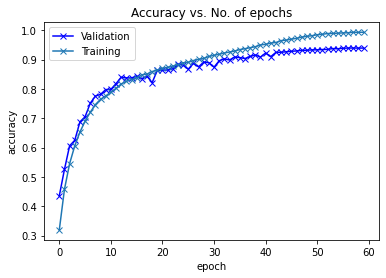

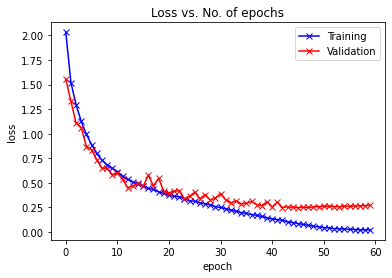

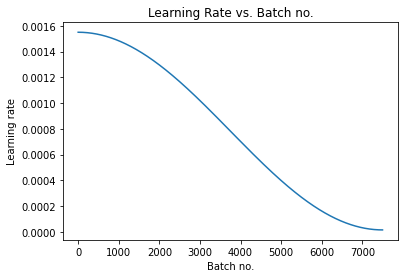

In [ ]:
plot_accuracies(history)
plt.show()
plot_losses(history)
plt.show()
plot_lrs(history)

In [ ]:
print(train_ds.classes)
print(valid_ds.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Function for prediction of a image.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Prediction of a single image

Label: airplane , Predicted: airplane


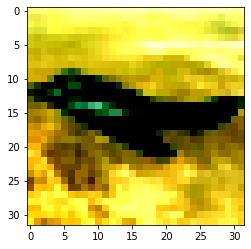

In [ ]:
img, label = valid_ds[110]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


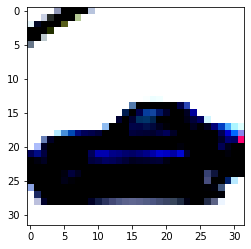

In [ ]:
img, label = valid_ds[1010]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


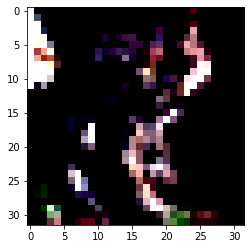

In [ ]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Saving the model

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/cifar10-resnet34.pth')

Loading the model for Sanity Check.

In [ ]:
model2 = to_device(ResNet34(3, 10), device)

In [ ]:
model2.load_state_dict(torch.load('/kaggle/working/cifar10-resnet34.pth'))

<All keys matched successfully>

In [ ]:
evaluate(model2, valid_dl)

{'val_loss': 0.2706180214881897, 'val_acc': 0.9392306804656982}

In [ ]:
modelbest=to_device(ResNet34(3, 10), device)
modelbest.load_state_dict(torch.load('/kaggle/working/cifar10-resnet34best.pth'))

<All keys matched successfully>

In [ ]:
evaluate(modelbest, valid_dl)

{'val_loss': 0.26551732420921326, 'val_acc': 0.9393268823623657}